# MNIST example using scivae

Here we just show a simple example of how the data we can encode & predict from the dataset.



In [1]:
import os
import shutil
import tempfile
import unittest
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scivae import Optimiser, VAE, Validate
from sciviso import Scatterplot



# Set the location of the mnist data
data_dir = '../tests/data/mnist/'
image_size = 28
# The more images/data you have the better it will be
num_images = 40000

# Set up the data format (you don't normally need to do this (i.e. a normal np array works best))
test_f = open(f'{data_dir}train-images-idx3-ubyte', 'rb')
test_f.read(16)
buf = test_f.read(image_size * image_size * num_images)
test_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(num_images, image_size * image_size)

# Read in teh training labels
f = open(f'{data_dir}train-labels-idx1-ubyte', 'rb')
f.read(8)
test_labels = []
for i in range(0, len(test_data)):
    buf = f.read(1)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    test_labels.append(labels[0])




## Configuration

The configuration is the design of the neural network, it has the following parameters:  

1. loss: this is the metric for the loss function, and it can be: 'mse'=mean squared error (for continuous data), or 'ce' for cross entropy (for binary data)
2. distance_metric: this is the distance metric between the distributions and can either be 'mmd': maximum mean discrepency, or kl: Kullback–Leibler (see this blog for details: https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/)
3. mmd_weight: this is how much you want to force the VAE to learn 
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 1}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'relu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'relu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}



In [6]:
# Create a configuration for the dataset
config = {'scale_data': True,
          'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 1}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'relu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'relu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()

None
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          100480      default_input[0][0]              
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 64)           8256        dense_5[0][0]                    
__________________________________________

34/34 [==============================] - 3s 78ms/step - loss: 33.0505 - val_loss: 33.6292
Epoch 50/100
34/34 [==============================] - 3s 78ms/step - loss: 33.0055 - val_loss: 33.5885
Epoch 51/100
34/34 [==============================] - 3s 75ms/step - loss: 32.9562 - val_loss: 33.5682
Epoch 52/100
34/34 [==============================] - 3s 80ms/step - loss: 32.9132 - val_loss: 33.5044
Epoch 53/100
34/34 [==============================] - 3s 77ms/step - loss: 32.8911 - val_loss: 33.5246
Epoch 54/100
34/34 [==============================] - 2s 73ms/step - loss: 32.8427 - val_loss: 33.4650
Epoch 55/100
34/34 [==============================] - 2s 73ms/step - loss: 32.8050 - val_loss: 33.4334
Epoch 56/100
34/34 [==============================] - 2s 73ms/step - loss: 32.7625 - val_loss: 33.4242
Epoch 57/100
34/34 [==============================] - 2s 72ms/step - loss: 32.7312 - val_loss: 33.3745
Epoch 58/100
34/34 [==============================] - 2s 72ms/step - loss: 32.7078 - v

In [7]:
encoding = vae.get_encoded_data()

## Visualise the reconstruction


Have a look at how good the reconstruction is from the latent space.

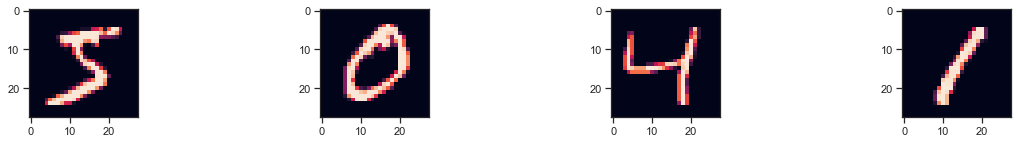

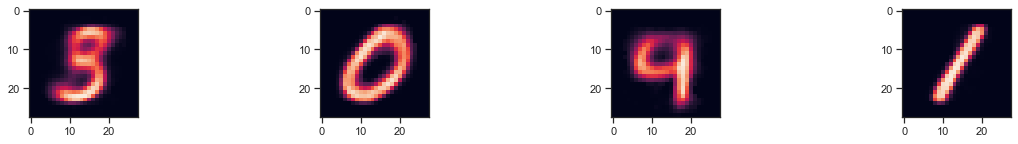

In [8]:
from sklearn.preprocessing import MinMaxScaler


# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))

plt.show()
# Ensure we're encoding and decoding the same dataset
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)

encoding = vae.encode_new_data(test_data_scaled)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
d = vae.decoder.predict(encoding)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))

plt.show()

## Visualise the latent space

Here we can have a look at the latent space by simply plotting the latent space & looking at how our labels separate.

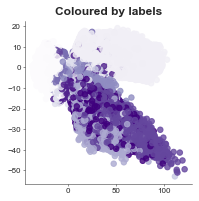

In [9]:
# Plot the latent space - have a look at the first two latent nodes
vis_df = pd.DataFrame()
vis_df['latent_0'] = encoding[:, 0]
vis_df['latent_1'] = encoding[:, 1]
vis_df['test_label'] = test_labels


# Zip the colours to make the labels into numeric values
lut = dict(zip(set(test_labels), sns.color_palette("Set1", len(set(test_labels)))))
row_colors2 = pd.DataFrame(test_labels)[0].map(lut)
vis_df['label'] = row_colors2
scatter = Scatterplot(vis_df, 'latent_0', 'latent_1',  
                      colour=vis_df['test_label'].values, title='Coloured by labels', 
                     add_legend=True)
scatter.plot()
plt.show()